In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import distance

from sklearn import preprocessing
from sklearn.preprocessing import Normalizer, MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.neighbors import NearestCentroid


In [21]:
df = pd.read_csv('../data/unsw/UNSW_NB15_training-set.csv')

df.head(1)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0


In [22]:
# encode categorical features
le = preprocessing.LabelEncoder()
df['proto'] = le.fit_transform(df['proto'])
df['service'] = le.fit_transform(df['service'])
df['state'] = le.fit_transform(df['state'])

df.head(1)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,117,0,4,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0


In [60]:
# separate features from labels
X = df.drop(['id', 'label', 'attack_cat'], axis=1)
X.columns = X.iloc[0]

y = le.fit_transform(df['attack_cat'])

y_label_map = dict(zip(le.classes_, le.transform(le.classes_)))

X.shape, y.shape


((82332, 42), (82332,))

In [24]:
# scale data using different scalers and compare

# data normalizer
scaler = Normalizer().fit(X)
X_normalizer = scaler.transform(X)

# min-madf scaler
scaler = MinMaxScaler().fit(X)
X_minmax = scaler.transform(X)

# robust scaler
scaler = RobustScaler().fit(X)
X_robust = scaler.transform(X)

# standard scaler
scaler = StandardScaler().fit(X)
X_standard = scaler.transform(X)

# quantile transformer
scaler = QuantileTransformer().fit(X)
X_quantile = scaler.transform(X)

# power transformer
scaler = PowerTransformer().fit(X)
X_power = scaler.transform(X)


In [25]:
# measure nearest shrunken centroid
def nearest_shrunken_centroid(X, y):
    clf = NearestCentroid(shrink_threshold=0.1)
    clf.fit(X, y)

    return clf.centroids_


In [33]:
# compute  Mahalanobis distance between the class centroids
def mahalanobis_distance(X, y):
    centroids = nearest_shrunken_centroid(X, y)
    distances = np.zeros((len(centroids), len(centroids)))

    for i in range(centroids.shape[0]):
        for j in range(centroids.shape[0]):
            if i != j:
                distances[i, j] = distance.mahalanobis(centroids[i], centroids[j], np.cov(X, rowvar=False))

    return distances


In [34]:
# compute the distance for unscaled data and each scaler's output

# unscaled data
distances = mahalanobis_distance(X, y)

# normalizer
distances_normalizer = mahalanobis_distance(X_normalizer, y)

# min-madf scaler
distances_minmax = mahalanobis_distance(X_minmax, y)

# robust scaler
distances_robust = mahalanobis_distance(X_robust, y)

# standard scaler
distances_standard = mahalanobis_distance(X_standard, y)

# quantile transformer
distances_quantile = mahalanobis_distance(X_quantile, y)

# power transformer
distances_power = mahalanobis_distance(X_power, y)


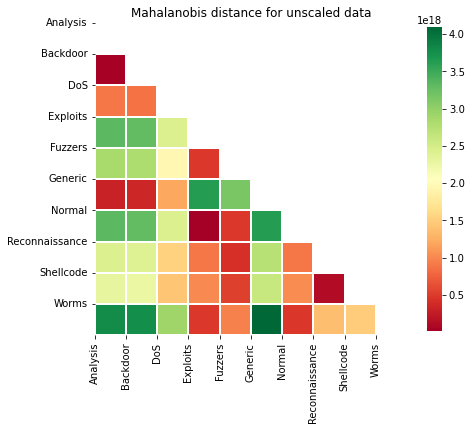

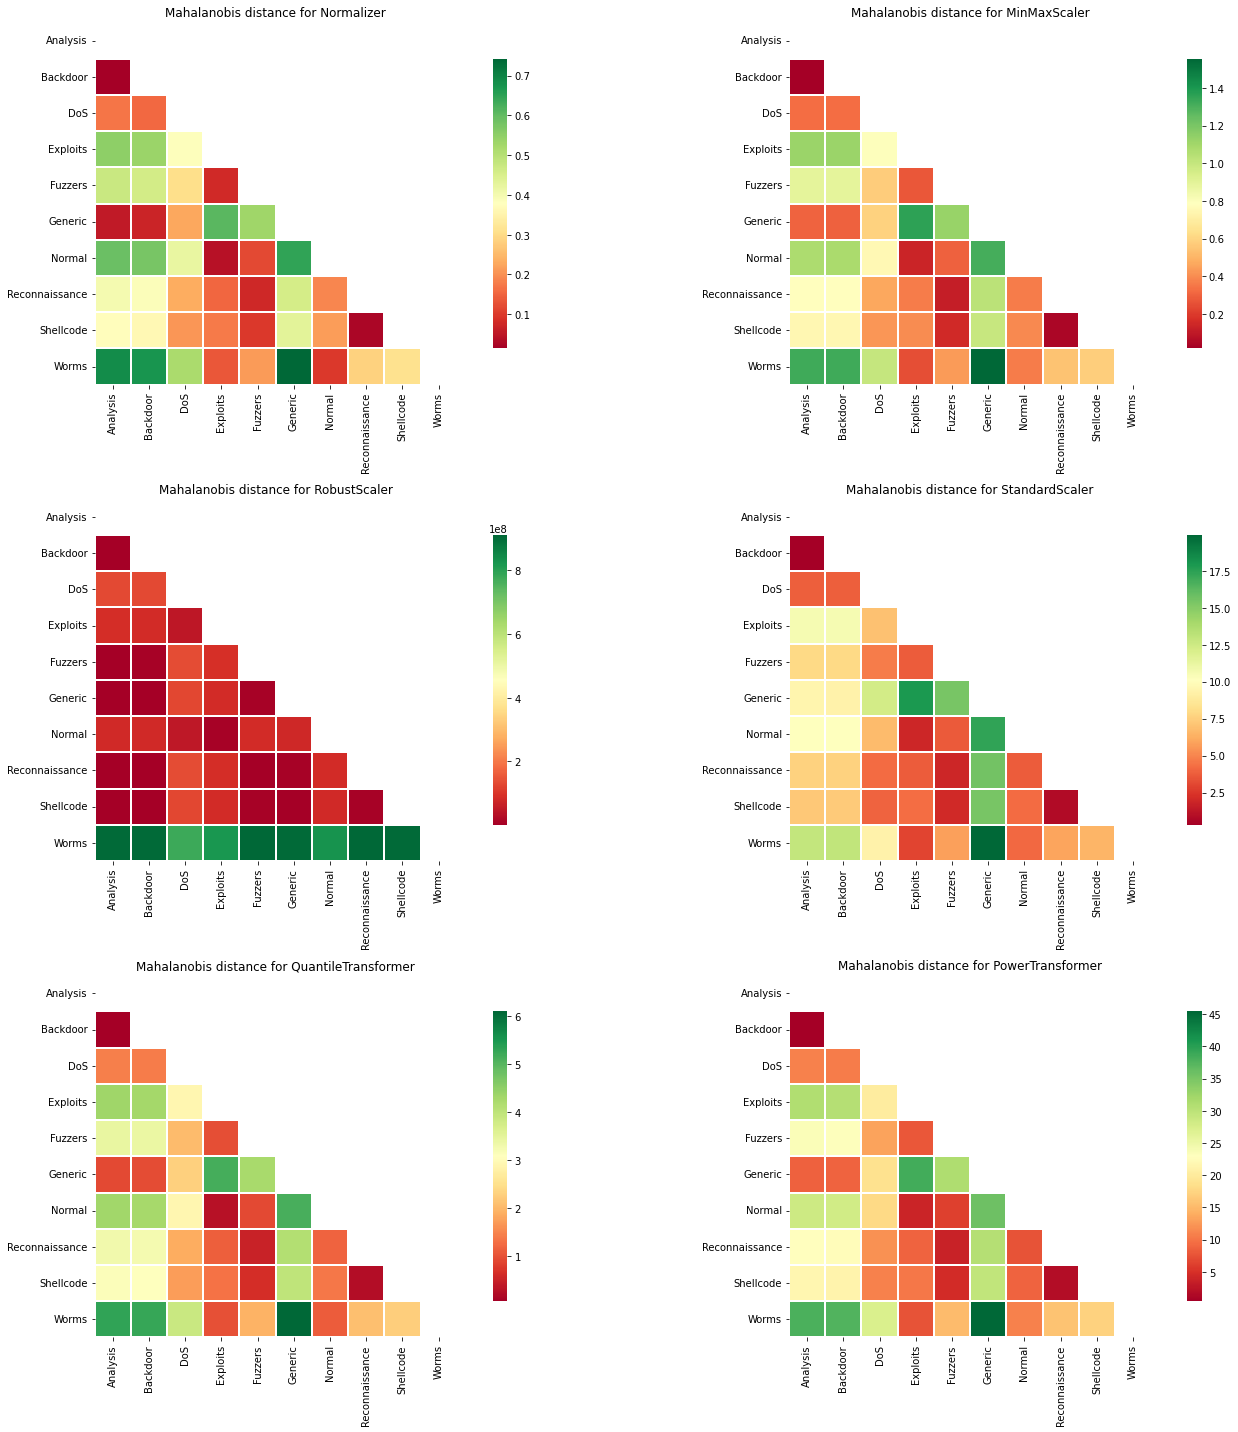

In [66]:
# plot heatmap for each set of distances

# create a boolean mask to remove redundant values from the plot
mask = np.zeros_like(distances)
mask[np.triu_indices_from(mask)] = True


def heatmap(data, ax=None, title=''):
    sns.heatmap(data, cmap='RdYlGn', mask=mask, ax=ax, linewidths=2, cbar_kws={'shrink': .8}, square=True)
    if ax:
        ax.set_title(title)
        ax.set_xticklabels(y_label_map.keys(), rotation=90)
        ax.set_yticklabels(y_label_map.keys(), rotation=0)


# unscaled data
plt.figure(figsize=(7, 7))
heatmap(distances)
plt.title('Mahalanobis distance for unscaled data')
plt.xticks(range(len(y_label_map)), y_label_map.keys(), rotation=90)
plt.yticks(range(len(y_label_map)), y_label_map.keys(), rotation=0)
plt.show()

# scaled data
fig, axis = plt.subplots(3, 2, figsize=(20, 20))

# normalizer
heatmap(distances_normalizer, ax=axis[0, 0], title='Mahalanobis distance for Normalizer')

# min-max
heatmap(distances_minmax, ax=axis[0, 1], title='Mahalanobis distance for MinMaxScaler')

# robust
heatmap(distances_robust, ax=axis[1, 0], title='Mahalanobis distance for RobustScaler')

# standard
heatmap(distances_standard, ax=axis[1, 1], title='Mahalanobis distance for StandardScaler')

# quantile
heatmap(distances_quantile, ax=axis[2, 0], title='Mahalanobis distance for QuantileTransformer')

# power
heatmap(distances_power, ax=axis[2, 1], title='Mahalanobis distance for PowerTransformer')

fig.tight_layout()
plt.show()
